In [66]:
import os
import time
import random
import datetime
import pytz

#Image manipulation packages
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split

#Tensorflow models libraries
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Input, BatchNormalization, Conv2DTranspose, Flatten, Dense
from tensorflow.keras.models import Model, load_model, save_model
from tensorflow.keras.applications import VGG19
#Alternative of pickle for larger files
import joblib
import pickle

#packages required to get the data uploaded on the drive
from googleapiclient.http import MediaIoBaseDownload
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
from googleapiclient.discovery import build
from google.colab import drive
import io
import random

In [2]:
# Google Drive API Code to authenticate access
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [3]:
#Code to load images from Drive
def load_drive_data(file_id):

    drive_service = build('drive', 'v3')
    request = drive_service.files().get_media(fileId=file_id)
    downloaded = io.BytesIO()
    downloader = MediaIoBaseDownload(downloaded, request)
    done = False
    while done is False:
        # _ is a placeholder for a progress object that we ignore.
        # (Our file is small, so we skip reporting progress.)
        _, done = downloader.next_chunk()

    downloaded.seek(0)

    # Joblib is used because of large file size
    f = joblib.load(downloaded)

    return f

#images downloaded are in the form of a dictionary, convert it to a numpy array
def dict_to_array(images):

    image_list = []
    for persons in images.keys():
        image_list.append(images[persons])
    
    return np.array(image_list)

#function to plot multiple images
def plot(images, figsize=(10, 10)):

    plt.figure(figsize=figsize)
    
    for index, image in enumerate(images):
        # display original
        ax = plt.subplot(2, len(images), index + 1)
        plt.imshow(image.reshape(image.shape[0], image.shape[1], image.shape[2]))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.show()

In [4]:
#images obtained are in the form of a dictionary and have values between 0-1, and are cropped so as to obtain just the facial images
#dictionary[person] = image_value

# Data description: Total facial images of 105 people with each person having a total of 6 images
# Input given is the file id of the file stored in drive
image_data = load_drive_data('1QZv7mWvvF8mnT0A2mA4OFSvxF1eqPd8g')
images = dict_to_array(image_data)

# Create data copy to local storage, can be accessed directly from there
with open('image_data.pickle', 'wb') as file:
    joblib.dump(images, file)

# Load the test set images required
# with open('/content/image_data.pickle', 'rb') as file:
#     images = joblib.load(file)

In [5]:
del (image_data)
images.shape

(630, 224, 224, 3)

In [6]:
# Block a % of image visible
# percent_mask is in the range 0 - 1
def create_masked_images(images, **kwargs):

    mask_shape = images.shape

    # default value for percentage of image to be masked
    percent_mask = 0.5
    if 'percent_mask' in kwargs:
        percent_mask = kwargs['percent_mask']

    # hide_axis = 2 => row axis
    hide_axis = 2
    if 'hide_axis' in kwargs:
        hide_axis = kwargs['hide_axis']
    
    # Always the 2nd axis ie columns are masked
    zero_shape = int(mask_shape[hide_axis]*percent_mask)//2
    one_shape = mask_shape[hide_axis] - zero_shape*2

    if 'partial_image' in kwargs:

        print("Hidden pixels and Visible Pixels Count: ",zero_shape, one_shape)
        # print(images[:, :, zero_shape: one_shape+zero_shape, :].shape)
        return images[:, :, zero_shape: one_shape+zero_shape, :]
    
    if hide_axis == 1:
        zero_shape = (mask_shape[0], zero_shape, mask_shape[2], mask_shape[3])
        one_shape = (mask_shape[0], one_shape, mask_shape[2], mask_shape[3])
    
    else:
        zero_shape = (mask_shape[0], mask_shape[1], zero_shape, mask_shape[3])
        one_shape = (mask_shape[0], mask_shape[1], one_shape, mask_shape[3])

    mask = np.concatenate((np.zeros(zero_shape), np.ones(one_shape), np.zeros(zero_shape)), axis=hide_axis)
    
    if 'show_boundary' in kwargs and kwargs['show_boundary']:
        mask_compliment = 1 - mask
        return mask*images + np.mean(images)*mask_compliment

    return mask*images, mask[0]


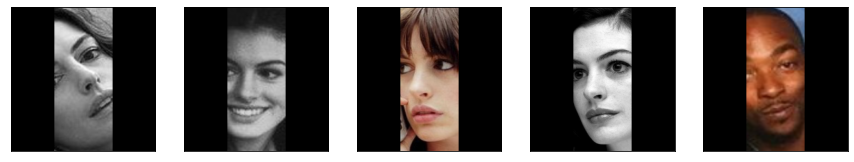

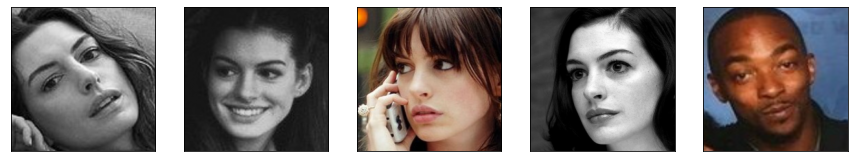

In [ ]:
plot(create_masked_images(images[50: 55], percent_mask = 0.6, hide_axis=2)[0], figsize=(15, 15))
plot(images[50: 55], figsize=(15, 15))

In [ ]:
# Initially 60% image is masked, 530 for training and 100 for testing.
# Reduce masking size if network doesnt optimize

In [7]:
masked_images, mask = create_masked_images(images, percent_mask = 0.6, hide_axis=2)

In [8]:
masked_images.shape, mask.shape

((630, 224, 224, 3), (224, 224, 3))

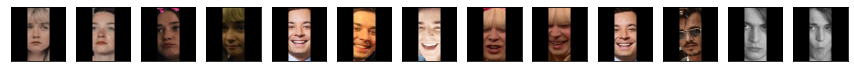

In [9]:
start, end = 290, 303
plot(masked_images[start: end], figsize=(15, 15))

In [10]:
def image_generator(image_shape):

    input_img = Input(shape=(224, 224, 3), dtype='float32')

    x = Conv2D(64, (5, 5), strides=1, dilation_rate=(1, 1), activation='relu', padding='same')(input_img)
    x = Conv2D(128, (3, 3), strides=2, dilation_rate=(1, 1), activation='relu', padding='same')(x)
    x = Conv2D(256, (3, 3), strides=1, dilation_rate=(1, 1), activation='relu', padding='same')(x)
    x = Conv2D(256, (3, 3), strides=1, dilation_rate=(2, 2), activation='relu', padding='same')(x)
    x = Conv2D(256, (3, 3), strides=1, dilation_rate=(4, 4), activation='relu', padding='same')(x)
    x = Conv2D(256, (3, 3), strides=1, dilation_rate=(8, 8), activation='relu', padding='same')(x)
    x = Conv2D(256, (3, 3), strides=1, dilation_rate=(1, 1), activation='relu', padding='same')(x)
    
    x = Conv2DTranspose(128, (4, 4), strides=2, dilation_rate=(1, 1), activation='relu', padding='same')(x)
    x = Conv2D(64, (3, 3), strides=1, dilation_rate=(1, 1), activation='relu', padding='same')(x)
    x = Conv2D(3, (3, 3), strides=1, dilation_rate=(1, 1), activation='relu', padding='same')(x)

    return Model(input_img, x, name='Generator')


def image_discriminator(image_shape):

    input_img = Input(shape=image_shape, dtype='float32')

    x = Conv2D(32, (5, 5), strides=2, activation='relu', padding='same')(input_img)
    x = Conv2D(64, (5, 5), strides=2, activation='relu', padding='same')(x)
    x = Conv2D(64, (5, 5), strides=2, activation='relu', padding='same')(x)
    x = Conv2D(64, (5, 5), strides=2, activation='relu', padding='same')(x)
    x = Conv2D(64, (5, 5), strides=2, activation='relu', padding='same')(x)

    x = Flatten()(x)
    x = Dense(512, activation='relu')(x)
    x = Dense(1, activation='sigmoid')(x)

    return Model(input_img, x, name='Discriminator')


    

In [68]:
gen_model = image_generator((224, 224, 3))
gen_model.summary()

Model: "Generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d_56 (Conv2D)           (None, 224, 224, 64)      4864      
_________________________________________________________________
conv2d_57 (Conv2D)           (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2d_58 (Conv2D)           (None, 112, 112, 256)     295168    
_________________________________________________________________
conv2d_59 (Conv2D)           (None, 112, 112, 256)     590080    
_________________________________________________________________
conv2d_60 (Conv2D)           (None, 112, 112, 256)     590080    
_________________________________________________________________
conv2d_61 (Conv2D)           (None, 112, 112, 256)     59

In [69]:
disc_model = image_discriminator(image_shape=(224, 224, 3))
disc_model.summary()

Model: "Discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d_65 (Conv2D)           (None, 112, 112, 32)      2432      
_________________________________________________________________
conv2d_66 (Conv2D)           (None, 56, 56, 64)        51264     
_________________________________________________________________
conv2d_67 (Conv2D)           (None, 28, 28, 64)        102464    
_________________________________________________________________
conv2d_68 (Conv2D)           (None, 14, 14, 64)        102464    
_________________________________________________________________
conv2d_69 (Conv2D)           (None, 7, 7, 64)          102464    
_________________________________________________________________
flatten_4 (Flatten)          (None, 3136)            

In [13]:
# Loss functions

def mse(y_true, y_pred):
    return tf.reduce_mean(tf.losses.mean_squared_error(y_true, y_pred))

# y_true is the output of the discriminator for actual images
# y_pred is the output of the discriminator for generator generated images

def discriminator_loss(y_true, y_pred, epsilon=1e-7):
    return -tf.reduce_mean(tf.math.log(tf.maximum(y_true, epsilon)) + tf.math.log(tf.maximum(1-y_pred, epsilon)))


# y_true is the actual image
# y_pred is the Generator generated image
# discriminator_pred is the output of the discriminator when given image generated by the generator
# alpha is used as a control variable to determine the importance of mse loss
# mask == mask_compliment
def generator_loss(y_true, y_pred, discriminator_pred, mask, alpha=0.0004, epsilon=1e-7):
    return mse(y_true, y_pred) - alpha*tf.reduce_mean(tf.math.log(tf.maximum(discriminator_pred, epsilon)))


#Tensorflow function to find psnr of an image

def psnr(y_true, y_pred):
    return tf.math.reduce_mean(tf.image.psnr(y_true, y_pred, max_val=1, name=None))

def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean((y_true - y_pred)**2))

In [62]:
def save_models(generator, discriminator, gen_filename='', disc_filename=''):

    save_model(generator, gen_filename)
    save_model(discriminator, disc_filename)


# To save the new logs
def save_logs(logs, previous_logs=None, logfile_name='', keys=None):

    temp = {}
    if previous_logs and keys:

        for key in keys:
            temp[key] = previous_logs[key] + logs[key]
    
    else:
        temp = logs
    
    with open(logfile_name, 'wb') as file:
        pickle.dump(temp, file)
    
    return True
        
# Load the logfile
def load_logs(logfile_name=None):

    if logfile_name:
        try:
            with open(logfile_name, 'rb') as file:
                temp_logs = pickle.load(file)

            print("Log file loaded in the form of a dictionary")

            return temp_logs

        except FileNotFoundError:
            print("No log file created, Returned an empty dictionary")
            return {}
            
    return False

In [70]:
# https://keras.io/guides/writing_a_training_loop_from_scratch/
# pass pre compiled generator and discriminator models as input to the function

# kwargs can contain train_data = (masked_images, actual_images), test_data = (masked_test, actual_test),
#                    epochs, batch_size, 
#                    train_disc_after,
#                    loss=(gen_loss_function, disc_loss_function),
#                    optimizer = (gen_optimizer, disc_optimizer)
#                    mask_compliment, accuracy_function,
#                    save_after, save_model

def train(gen_model, disc_model, **kwargs):

    test_present = True if 'test_data' in kwargs else False

    if 'train_data' in kwargs:
        masked_images, actual_images = kwargs['train_data'][0], kwargs['train_data'][1]

    if 'test_data' in kwargs:
        masked_test, actual_test = kwargs['test_data'][0], kwargs['test_data'][1]  

    # Default epoch count
    epochs, epochs_done = 100, 0
    if 'epochs' in kwargs:
        epochs = kwargs['epochs']
        epochs_done = kwargs['epochs_done']
    
    # Default batch_size value
    batch_size = 32
    if 'batch_size' in kwargs:
        batch_size = kwargs['batch_size']

    if 'loss' in kwargs:
        gen_loss_function, disc_loss_function = kwargs['loss'][0], kwargs['loss'][1]

    if 'optimizer' in kwargs:
        gen_optimizer, disc_optimizer = kwargs['optimizer'][0], kwargs['optimizer'][1]
    
    if 'mask_compliment' in kwargs:
        mask_compliment = kwargs['mask_compliment']
    
    if 'metric' in kwargs:
        accuracy = kwargs['metric']

    
    train_after = 1
    if 'train_disc_after' in kwargs:
        train_after = kwargs['train_disc_after'] 

    save_after = 10
    if 'save_after' and 'save_models' in kwargs:
        save_after = kwargs['save_after']
        save = kwargs['save_models']
        
    if 'history' and 'save_logs' in kwargs:
        history = kwargs['history']
        save_logs = kwargs['save_logs']

    if 'model_weights' in kwargs:
        gen_model = load_model(kwargs['model_weights'][0], custom_objects={'generator_loss': gen_loss_function, 'generator_optimizer': gen_optimizer})
        disc_model = load_model(kwargs['model_weights'][1], custom_objects={'discriminator_loss': disc_loss_function, 'discriminator_optimizer': disc_optimizer})
        print("Model Weights Loaded")
        

    # List to store the loss and accuracy values after each epochs
    global gen_losses, disc_losses, test_gen_losses, test_disc_losses
    global gen_accuracy, test_gen_accuracy
    global temp_history

    gen_losses, disc_losses, gen_accuracy, temp_history = [], [], [], {}
    test_gen_losses, test_disc_losses, test_gen_accuracy = [], [], []
    # Train for desired number of epochs
    for step in range(epochs):
        
        print(f'Epoch {step+1}/{epochs}', end='\n[')
        start_time = time.time()

        gen_loss, gen_acc = 0, 0

        # Reset discriminator loss only for the epoch when discriminator is to be trained, else keep it same as previous epochs
        if step % train_after == 0:
             disc_loss = 0

        # train on batch data
        batch_steps = masked_images.shape[0]//batch_size

        for batch_step in range(batch_steps):
            
            gen_batch_loss, disc_batch_loss = 0, 0
            gen_batch_acc = 0
            start, end = batch_step*batch_size, (batch_step+1)*batch_size
            

            with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
                
                # print(f'5 {gen_model.get_weights()[0][0][0]}')
                # Generator applied to masked images
                gen_train = gen_model(masked_images[start: end], training=True)

                # Discriminator makes prediction on both masked and actual images
                disc_masked = disc_model(gen_train, training=True)
                disc_actual = disc_model(actual_images[start: end], training=True)

                # Discriminator generates loss using y_true = ones/zero, y_pred = actual/masked_images
                # if allows discriminator to be trained only after mentioned number of epochs
                if step % train_after == 0:

                    disc_batch_loss = disc_loss_function(disc_actual, disc_masked)
                    
                # Generator loss & accuracy
                gen_batch_loss = gen_loss_function(actual_images[start: end], gen_train, disc_masked, mask_compliment)
                gen_batch_acc = accuracy(actual_images[start: end], gen_train)

                # Back propagation on generator and discriminator and then apply gradients
                gen_grads = gen_tape.gradient(gen_batch_loss, gen_model.trainable_weights)
                gen_optimizer.apply_gradients(zip(gen_grads, gen_model.trainable_weights))

                if step % train_after == 0:
                    disc_grads = disc_tape.gradient(disc_batch_loss, disc_model.trainable_weights)
                    disc_optimizer.apply_gradients(zip(disc_grads, disc_model.trainable_weights))

                # Add loss to the epoch loss
                gen_loss += gen_batch_loss
                disc_loss += disc_batch_loss    
                gen_acc += gen_batch_acc

            print('===', end='')
        
        print(']', end='  ')
        # Add mean of batch_losses into loss_list
        gen_losses.append(gen_loss/batch_steps)
        disc_losses.append(disc_loss/batch_steps)

        # Add mean of batch accuracy into accuracy list
        gen_accuracy.append(gen_acc/batch_steps)

        # Calculate the time elapsed for the total epoch
        elapsed_time = time.time() - start_time
        
        # Validation dataset
        if 'test_data' in kwargs:
            test_gen_pred = gen_model(masked_test)
            
            test_disc_masked = disc_model(test_gen_pred)
            test_disc_actual = disc_model(actual_test)
            zeros, ones = tf.zeros((1, masked_test.shape[0])), tf.ones((1, actual_test.shape[0]))

            test_psnr = accuracy_function(actual_test, test_gen_pred)
            test_gen_loss = gen_loss_function(actual_test, test_gen_pred, test_disc_masked, mask_compliment)
            # test_disc_loss = tf.add(tf.cast(disc_loss_function(zeros, test_disc_masked), tf.float32), tf.cast(disc_loss_function(ones, test_disc_actual), tf.float32))
            test_disc_loss = disc_loss_function(test_disc_actual, test_disc_masked)

            # Append losses to the loss list
            test_gen_losses.append(test_gen_loss)
            test_disc_losses.append(test_disc_loss)
            test_gen_accuracy.append(test_psnr)

            print(f'Gen Loss = {gen_loss/batch_steps:.4f}, Disc Loss = {disc_loss/batch_steps:.4f}, PSNR = {gen_acc/batch_steps:.3f}, Test Gen Loss = {test_gen_loss:.4f}, Test Disc Loss = {test_disc_loss:.4f}, Test PSNR = {test_psnr:.3f} ')    

        else:
            print(f'Gen Loss = {gen_loss/batch_steps:.4f}, Disc Loss = {disc_loss/batch_steps:.4f}, PSNR = {gen_acc/batch_steps:.3f}')

        print(f'Time per epoch: {time.strftime("%H:%M:%S", time.gmtime(elapsed_time))}')
        print()

        # save the model
        if step % save_after == 0 or step == epochs-1:
            save(gen_model, disc_model,
                 gen_filename=f'Generator_{step+1+epochs_done}epochs.h5', 
                 disc_filename=f'Discriminator_{step+1+epochs_done}epochs.h5')

            if 'history' in kwargs:
                
                # If there are no keys in the logfile
                if history == {}:
                    keys = ['generator_losses', 'disc_losses', 'psnr']
                    
                    if test_present:
                        keys.append('test_generator_losses')
                        keys.append('test_discriminator_losses')
                        keys.append('test_psnr')
                
                else:
                    keys = history.keys()

                if test_present:
                    save_logs(logs={'generator_loss': gen_losses, 'discriminator_loss':disc_losses, 'psnr':gen_accuracy,
                                    'test_generator_loss':test_gen_losses, 'test_discriminator_loss':test_disc_losses, 'test_psnr':test_gen_accuracy},
                            previous_logs=history,
                            logfile_name=f'logs_{step+1+epochs_done}epochs.pickle',
                            keys=keys)

                else:
                    save_logs(logs={'generator_loss': gen_losses, 'discriminator_loss':disc_losses, 'psnr':gen_accuracy},
                              previous_logs=history,
                              logfile_name=f'logs_{step+1+epochs_done}epochs.pickle',
                              keys=keys)

                    
                # Update current logs
                # Make sure that the logfile is placed in the root folder if pre-existing logs are to be read.
                history = load_logs(logfile_name=f'logs_{step+1+epochs_done}epochs.pickle')

            # Reset the losses as they are being saved to avoid repeatation
            gen_losses, disc_losses, gen_accuracy = [], [], []


In [71]:
# Common parameters for generator and discriminator

# metrics = [tf.metrics.RootMeanSquaredError]
batch_size = 128
epochs = 60
epochs_done = 0
learning_rate = 0.001
epsilon = 1e-8
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(learning_rate,
                                                             decay_steps=10000, 
                                                             decay_rate=0.9,
                                                             staircase=True)

gen_optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule, epsilon=epsilon)
disc_optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule, epsilon=epsilon)

save_after = 20
train_disc_after = 5

gen_loss = generator_loss
disc_loss = discriminator_loss

train_data = (masked_images[: 512], images[: 512])
test_data = (masked_images[500: 600], images[500: 600])
loss = (gen_loss, disc_loss)
mask_compliment = 1 - mask
accuracy_function = psnr

logs = load_logs(logfile_name='logs_71epochs.pickle')
print("Keys in Dictionary: ", logs.keys())
try:
    print("Length: ", len(logs['generator_loss']))
except KeyError:
    pass

No log file created, Returned an empty dictionary
Keys in Dictionary:  dict_keys([])


In [72]:
# Run this cell only if the model is to be trained from the beginning
gen_model.compile(optimizer=gen_optimizer, loss=gen_loss)
disc_model.compile(optimizer=disc_optimizer, loss=disc_loss)

In [ ]:
gen_model = load_model('/content/Generator_71epochs.h5', custom_objects={'generator_loss': gen_loss})
disc_model = load_model('/content/Discriminator_71epochs.h5', custom_objects={'discriminator_loss':disc_loss})

In [ ]:
# kwargs contain train_data = (masked_images, actual_images), test_data = (masked_test, actual_test),
#                    epochs, batch_size, 
#                    train_disc_after,
#                    loss=(gen_loss_function, disc_loss_function), 
#                    optimizer = (optimizer, optimizer),
#                    mask_compliment, accuracy_function,
#                    save_after, checkpoint_function,

train(gen_model, disc_model, 
      train_data=train_data,
      test_data = test_data,
      epochs=epochs, epochs_done=epochs_done, 
      train_disc_after=train_disc_after,
      batch_size=batch_size, 
      loss=(gen_loss, disc_loss), 
      optimizer=(gen_optimizer, disc_optimizer), 
      mask_compliment=mask_compliment, 
      metric=accuracy_function,
      save_after=save_after, save_models=save_models,
      history=logs, save_logs=save_logs,
      )

# Load the logs of the completely trained model
logs = load_logs(logfile_name=f'logs_{epochs+epochs_done}epochs.pickle')

Epoch 1/60
[============]  Gen Loss = 0.1979, Disc Loss = 1.3745, PSNR = 7.709, Test Gen Loss = 5.5068, Test Disc Loss = 3.1667, Test PSNR = -7.201 
Time per epoch: 00:09:26

Log file loaded in the form of a dictionary
Epoch 2/60
[============]  Gen Loss = 1.3779, Disc Loss = 1.3745, PSNR = 4.304, Test Gen Loss = 0.2664, Test Disc Loss = 0.9513, Test PSNR = 6.165 
Time per epoch: 00:05:58

Epoch 3/60
[============]  Gen Loss = 0.2430, Disc Loss = 1.3745, PSNR = 6.620, Test Gen Loss = 0.2650, Test Disc Loss = 0.9560, Test PSNR = 6.191 
Time per epoch: 00:05:57

Epoch 4/60
[============]  Gen Loss = 0.2373, Disc Loss = 1.3745, PSNR = 6.731, Test Gen Loss = 0.2515, Test Disc Loss = 0.9818, Test PSNR = 6.434 
Time per epoch: 00:05:59

Epoch 5/60
[============]  Gen Loss = 0.2176, Disc Loss = 1.3745, PSNR = 7.141, Test Gen Loss = 0.2102, Test Disc Loss = 1.0696, Test PSNR = 7.268 
Time per epoch: 00:05:56

Epoch 6/60
[============]  Gen Loss = 0.1489, Disc Loss = 1.2342, PSNR = 9.007, Test 

In [37]:
# Run this cell only if the above cell is interrupted or threw some error
# Load the logs of the completely trained model
logs = load_logs(logfile_name=f'logs_{epochs+epochs_done}epochs.pickle')

No log file created, Returned an empty dictionary


Generated Images


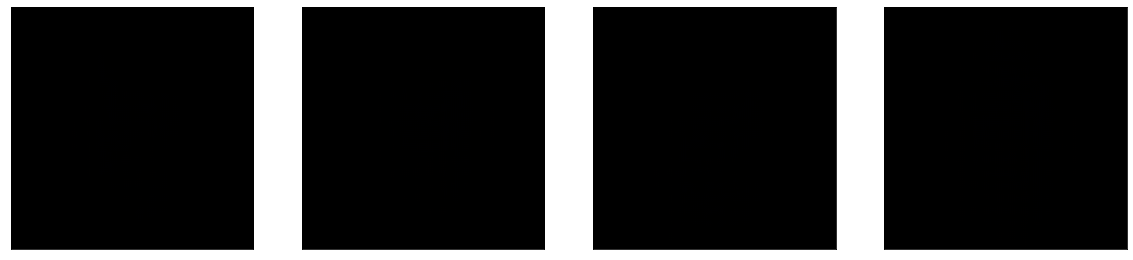

Masked Images


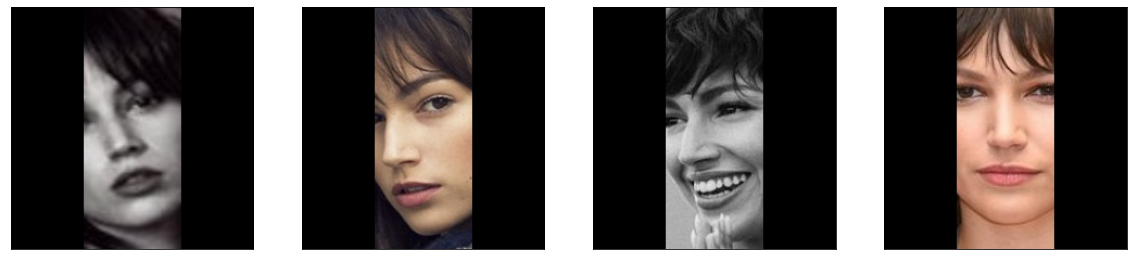

Actual Clear Images


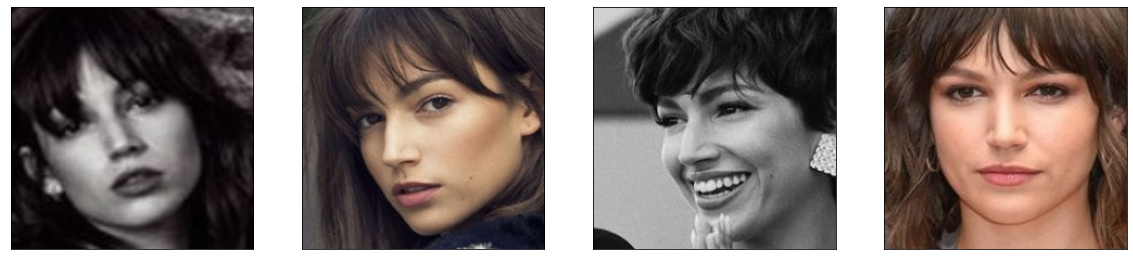

PSNR: 7.900245666503906
MSE: 0.17014674842357635
Masked PSNR: 12.217546463012695
Masked PSNR: 0.07025428315718776


In [52]:
# start = np.random.randint(600, 626)
start = np.random.randint(600, 626)
count = 4
end = start + count
figsize = (20, 20)

gen_imgs = gen_model.predict(masked_images[start: end])

print("Generated Images")
plot(gen_imgs, figsize=figsize)

print("Masked Images")
plot(masked_images[start: end], figsize=figsize)

print("Actual Clear Images")
plot(images[start: end], figsize=figsize)

print(f"PSNR: {psnr(images[start: end], gen_imgs)}")
print(f"MSE: {mse(images[start: end], gen_imgs)}")
print(f'RMSE: {rmse(images[start: end], gen_imgs)}')

# Metrics on masked images
print(f"Masked PSNR: {psnr((1-mask)*images[start: end], (1-mask)*gen_imgs)}")
print(f"Masked PSNR: {mse((1-mask)*images[start: end], (1-mask)*gen_imgs)}")

In [25]:
def plot_curve(train_data=None, validation_data=None, name='', xlabel='', ylabel=''):

    if train_data:
        plt.plot(train_data, label=f'Train {name}')
    
    if validation_data:
        plt.plot(validation_data, label=f'Test {name}')

    if xlabel:
        plt.xlabel(xlabel)
    
    if ylabel:
        plt.ylabel(ylabel)
    
    if name:
        plt.legend()

    plt.show()    

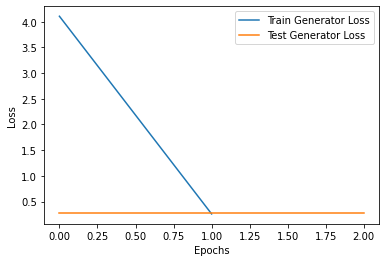

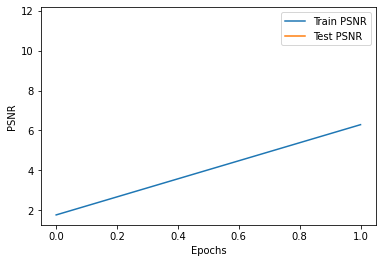

In [26]:
plot_curve(logs['generator_loss'], logs['test_generator_loss'], name='Generator Loss', xlabel='Epochs', ylabel='Loss')
plot_curve(logs['psnr'], logs['test_psnr'], name='PSNR', xlabel='Epochs', ylabel='PSNR')

In [29]:
logs['test_psnr']

<tf.Tensor: shape=(), dtype=float32, numpy=11.675207>

2.4.1
